### Setup Code Environment

In [1]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import seaborn as sns
%matplotlib inline

### Initialize service code data structures
- Service code / service name map
- Service code histogram

In [2]:
h_file = open("./serviceCodesCount.tsv","r")

code_name_map = {}
code_histogram = {}
                    
patternobj = re.compile('^([0-9a-z]+)\s\|\s([0-9a-z\s]+)$')

for fields in csv.reader(h_file, delimiter="\t"):
    matchobj = patternobj.match(fields[0])
    
    cur_code = matchobj.group(1)
    code_name_map[cur_code] = matchobj.group(2)
    code_histogram[cur_code] = float(fields[1])
    
h_file.close()

### Plot Cincinnati 311 Service Code Statistics
- References
  - [Descending Array Sort](http://stackoverflow.com/questions/14875248/python-numpy-sort-array)
  - [Change Plot Font Size](http://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid)

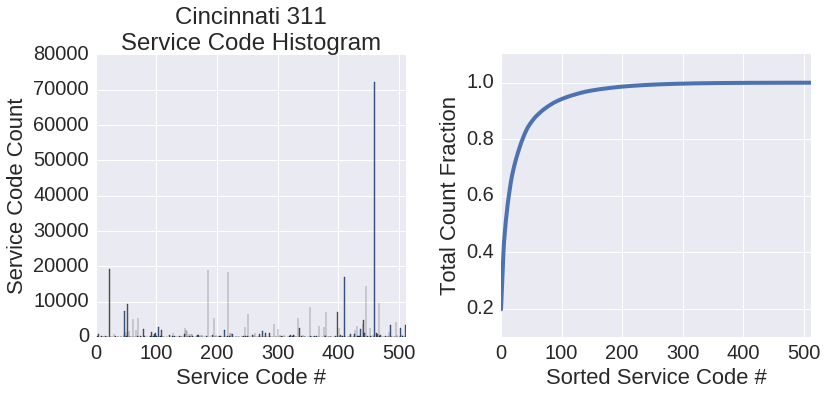

In [3]:
total_count_fraction = code_histogram.values()
total_count_fraction.sort()

total_count_fraction = total_count_fraction[::-1]
total_count_fraction /= np.sum(total_count_fraction)
total_count_fraction = np.cumsum(total_count_fraction)

sns.set(font_scale=2)
f,h_ax = plt.subplots(1,2,figsize=(12,6))
h_ax[0].bar(range(0,len(code_histogram.values())),
            code_histogram.values())
h_ax[0].set_xlim((0,len(total_count_fraction)))
h_ax[0].set_xlabel('Service Code #')
h_ax[0].set_ylabel('Service Code Count')
h_ax[0].set_title('Cincinnati 311\nService Code Histogram')

h_ax[1].plot(total_count_fraction, linewidth=4)
h_ax[1].set_xlim((0,len(total_count_fraction)))
h_ax[1].set_xlabel('Sorted Service Code #')
h_ax[1].set_ylabel('Total Count Fraction')
f.tight_layout()
plt.savefig("./cincinatti311Stats.png")

### Cluster service code names
- Compute Term Frequency Inverse Document Frequency (TF-IDF) feature vectors
- Apply the K-means algorithm to cluster service code names based on their TF-IDF feature vector
- References:
  - Rose, B. ["Document Clustering in Python"](http://brandonrose.org/clustering)
  - [Text pre-processing to reduce dictionary size](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

In [4]:
from nltk.stem.snowball import SnowballStemmer

def tokenize(text):
    """ Extracts unigrams (i.e. words) from a string that contains
    a service code name.
    
    Args:
        text: String that stores a service code name
    
    Returns:
        filtered_tokens: List of words contained in a service code name"""
    tokens = [word.lower() for word in nltk.word_tokenize(text)]

    filtered_tokens =\
        filter(lambda elem: re.match('^[a-z]+$', elem) != None,
               tokens)
        
    filtered_tokens =\
        map(lambda elem: re.sub("\s+"," ", elem),
            filtered_tokens)

    return filtered_tokens

def tokenize_and_stem(text):
    """ Applies the Snowball stemmer to unigrams (i.e. words) extracted
    from a string that contains a service code name.
    
    Args:
        text: String that stores a service code name
    
    Returns:
        filtered_tokens: List of words contained in a service code name"""
    stemmer = SnowballStemmer('english')

    tokens = [word.lower() for word in nltk.word_tokenize(text)]

    filtered_tokens =\
        filter(lambda elem: re.match('^[a-z]+$', elem) != None,
               tokens)

    filtered_tokens =\
        map(lambda elem: re.sub("\s+"," ", elem),
            filtered_tokens)

    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return filtered_tokens

def compute_tfidf_features(code_name_map,
                           tokenizer,
                           params):
    """ Constructs a Term Frequency Inverse Document Frequency (TF-IDF)
    matrix for the Cincinnati 311 service code names.
    
    Args:
        code_name_map: Dictionary that stores the mapping of service
                       codes to service names
        
        tokenizer: Function that transforms a string into a list of
                   words
                   
        params: Dictionary that stores parameters that configure the
                TfidfVectorizer class constructor
                
                - mindocumentcount: Minimum number of term occurrences
                in separate service code names
                
                - maxdocumentfrequency: Maximum document frequency
    
    Returns:
        Tuple that stores a TF-IDF matrix and a TfidfVectorizer class
        object.
        
        Index:   Description:
        -----    -----------
          0      TF-IDF matrix
          1      TfidfVectorizer class object"""
    token_count = 0
    for key in code_name_map.keys():
        token_count += len(tokenize(code_name_map[key]))

    num_codes = len(code_name_map.keys())

    min_df = float(params['mindocumentcount']) / num_codes
    
    tfidf_vectorizer =\
        TfidfVectorizer(max_df=params['maxdocumentfrequency'],
                        min_df=min_df,
                        stop_words = 'english',
                        max_features = token_count,
                        use_idf=True,
                        tokenizer=tokenizer,
                        ngram_range=(1,1))

    tfidf_matrix =\
        tfidf_vectorizer.fit_transform(code_name_map.values())

    return (tfidf_matrix,
            tfidf_vectorizer)

def cluster_311_services(tfidf_matrix,
                         num_clusters,
                         random_seed):
    """Applies the K-means algorithm to cluster Cincinnati 311 service
    codes based on their service name Term Frequency Inverse Document
    Frequency (TF-IDF) feature vector.
    
    Args:
        tfidf_matrix: Cincinnati 311 service names TF-IDF feature matrix
        
        num_clusters: K-means algorithm number of clusters input
        
        random_seed: K-means algorithm random seed input:
    
    Returns:
        clusterid_code_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service code

        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name"""
    km = KMeans(n_clusters = num_clusters,
                random_state=np.random.RandomState(seed=random_seed))

    km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()

    clusterid_code_map = defaultdict(list)
    clusterid_name_map = defaultdict(list)

    codes = code_name_map.keys()
    names = code_name_map.values()

    for idx in range(0, len(codes)):
        clusterid_code_map[clusters[idx]].append(codes[idx])
        clusterid_name_map[clusters[idx]].append(names[idx])
        
    return (clusterid_code_map,
            clusterid_name_map)

def compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram):
    """ Computes the total Cincinnati 311 requests / service
    names cluster
    
    Args:
        clusterid_code_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service code

        code_histogram: Dictionary that stores the number of 
                        occurrences for each Cincinnati 311 service 
                        code

    Returns:
        clusterid_total_count: Dictionary that stores the total
                               Cincinnati 311 requests / service
                               names cluster"""
    clusterid_total_count = defaultdict(int)
    
    num_clusters = len(clusterid_code_map.keys())

    for cur_cluster_id in range(0, num_clusters):
        for cur_code in clusterid_code_map[cur_cluster_id]:
            clusterid_total_count[cur_cluster_id] +=\
                code_histogram[cur_code]
    
    return clusterid_total_count

def print_cluster_stats(clusterid_name_map,
                        clusterid_total_count):
    """ Prints the total number of codes and total requests count
    for each Cincinnati 311 service names cluster.
    
    Args:
        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name

        clusterid_total_count: Dictionary that stores the total
                               Cincinnati 311 requests / service
                               names cluster

    Returns:
        None"""
    num_clusters = len(clusterid_total_count.keys())

    for cur_cluster_id in range(0, num_clusters):

        print "clusterid %d | # of codes: %d | total count: %d" %\
            (cur_cluster_id,
            len(clusterid_name_map[cur_cluster_id]),
            clusterid_total_count[cur_cluster_id])

def eval_maxcount_clusterid(clusterid_code_map,
                            clusterid_total_count,
                            code_histogram):
    """ This function performs the following two operations:

    1.) Plots the requests count for each service name in the
        maximum count service names cluster.

    2. Prints the maximum count service name in the maximum count
       service names cluster
    
    Args:
        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name

        clusterid_total_count: Dictionary that stores the total
                               Cincinnati 311 requests / service
                               names cluster

        code_histogram: Dictionary that stores the number of 
                        occurrences for each Cincinnati 311 service 
                        code
    
    Returns:
        None"""
    num_clusters = len(clusterid_code_map.keys())

    contains_multiple_codes = np.empty(num_clusters, dtype=bool)

    for idx in range(0, num_clusters):
        contains_multiple_codes[idx] = len(clusterid_code_map[idx]) > 1

    filtered_clusterid =\
        np.array(clusterid_total_count.keys())
        
    filtered_total_counts =\
        np.array(clusterid_total_count.values())

    filtered_clusterid =\
        filtered_clusterid[contains_multiple_codes]

    filtered_total_counts =\
        filtered_total_counts[contains_multiple_codes]

    max_count_idx = np.argmax(filtered_total_counts)

    maxcount_clusterid = filtered_clusterid[max_count_idx]
    
    cluster_code_counts =\
        np.zeros(len(clusterid_code_map[maxcount_clusterid]))

    for idx in range(0, len(cluster_code_counts)):
        key = clusterid_code_map[maxcount_clusterid][idx]
        cluster_code_counts[idx] = code_histogram[key]

    plt.bar(range(0,len(cluster_code_counts)),cluster_code_counts)
    plt.grid(True)
    plt.xlabel('Service Code #')
    plt.ylabel('Service Code Count')
    plt.title('Cluster #%d Service Code Histogram' %\
              (maxcount_clusterid))

    max_idx = np.argmax(cluster_code_counts)
    print "max count code: %s" %\
        (clusterid_code_map[maxcount_clusterid][max_idx])
        
def add_new_cluster(from_clusterid,
                    service_code,
                    clusterid_total_count,
                    clusterid_code_map,
                    clusterid_name_map):
    """Creates a new service name(s) cluster

    Args:
        from_clusterid: Integer that refers to a service names
                        cluster that is being split
                        
        servicecode: String that refers to a 311 service code

        clusterid_code_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service code

        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name
    
    Returns:
        None - Service names cluster data structures are updated
        in place"""
    code_idx =\
        np.argwhere(np.array(clusterid_code_map[from_clusterid]) ==\
                    service_code)[0][0]
    
    service_name = clusterid_name_map[from_clusterid][code_idx]

    next_clusterid = (clusterid_code_map.keys()[-1])+1

    clusterid_code_map[from_clusterid] =\
        filter(lambda elem: elem != service_code,
               clusterid_code_map[from_clusterid])
    
    clusterid_name_map[from_clusterid] =\
        filter(lambda elem: elem != service_name,
               clusterid_name_map[from_clusterid])
    
    clusterid_code_map[next_clusterid] = [service_code]
    clusterid_name_map[next_clusterid] = [service_name]

def print_clustered_servicenames(cur_clusterid,
                                 clusterid_name_map):
    """Prints the Cincinnati 311 service names(s) for a specific 
    Cincinnati 311 service names cluster

    Args:
        cur_clusterid: Integer that refers to a specific Cincinnati 311
                       service names cluster
    
        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name"""
    for cur_name in clusterid_name_map[cur_clusterid]:
        print "%s" % (cur_name)

def plot_cluster_stats(clusterid_code_map,
                       clusterid_total_count):
    """Plots the following service name(s) cluster statistics:

    - Number of service code(s) / service name(s) cluster
    - Total number of requests / service name(s) cluster

    Args:
        clusterid_name_map: Dictionary that stores the mapping of
                            cluster identifier to Cincinnati 311
                            service name
                            
        clusterid_total_count: Dictionary that stores the total
                               Cincinnati 311 requests / service
                               names cluster

    Returns:
        None"""
    codes_per_cluster =\
        map(lambda elem: len(elem), clusterid_code_map.values())

    num_clusters = len(codes_per_cluster)

    f,h_ax = plt.subplots(1,2,figsize=(12,6))
    h_ax[0].bar(range(0,num_clusters), codes_per_cluster)
    h_ax[0].set_xlabel('Service Name(s) cluster id')
    h_ax[0].set_ylabel('Number of service codes / cluster')
    h_ax[1].bar(range(0,num_clusters), clusterid_total_count.values())
    h_ax[1].set_xlabel('Service Name(s) cluster id')
    h_ax[1].set_ylabel('Total number of requests')
    plt.tight_layout()

### Apply a word tokenizer to the service names and construct a TF-IDF feature matrix

In [5]:
params = {'maxdocumentfrequency': 0.25,
          'mindocumentcount': 10}

(tfidf_matrix,
 tfidf_vectorizer) = compute_tfidf_features(code_name_map,
                                            tokenize,
                                            params)

print "# of terms: %d" % (tfidf_matrix.shape[1])
print tfidf_vectorizer.get_feature_names()

# of terms: 31
[u'additnal', u'building', u'cart', u'com', u'complaint', u'compliment', u'damage', u'default', u'dote', u'gallon', u'grassweeds', u'haz', u'ins', u'litter', u'missing', u'new', u'priv', u'prop', u'property', u'recycling', u'repair', u'req', u'request', u'res', u'row', u'service', u'sign', u'street', u'tall', u'trash', u'tree']


### Apply the [K-means algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the Cincinnati 311 service names based on their TF-IDF feature vector

In [6]:
num_clusters = 20
kmeans_seed = 3806933558

(clusterid_code_map,
 clusterid_name_map) = cluster_311_services(tfidf_matrix,
                                            num_clusters,
                                            kmeans_seed)

clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 28 | total count: 28012
clusterid 1 | # of codes: 187 | total count: 148910
clusterid 2 | # of codes: 14 | total count: 993
clusterid 3 | # of codes: 16 | total count: 6438
clusterid 4 | # of codes: 34 | total count: 30743
clusterid 5 | # of codes: 15 | total count: 3025
clusterid 6 | # of codes: 31 | total count: 7614
clusterid 7 | # of codes: 16 | total count: 7260
clusterid 8 | # of codes: 14 | total count: 30238
clusterid 9 | # of codes: 19 | total count: 14557
clusterid 10 | # of codes: 25 | total count: 32466
clusterid 11 | # of codes: 12 | total count: 2864
clusterid 12 | # of codes: 12 | total count: 10177
clusterid 13 | # of codes: 16 | total count: 2527
clusterid 14 | # of codes: 11 | total count: 5902
clusterid 15 | # of codes: 12 | total count: 426
clusterid 16 | # of codes: 14 | total count: 21972
clusterid 17 | # of codes: 11 | total count: 216
clusterid 18 | # of codes: 11 | total count: 1921
clusterid 19 | # of codes: 14 | total count: 9403


### Plot the service code histogram for the maximum size cluster

max count code: mtlfrn


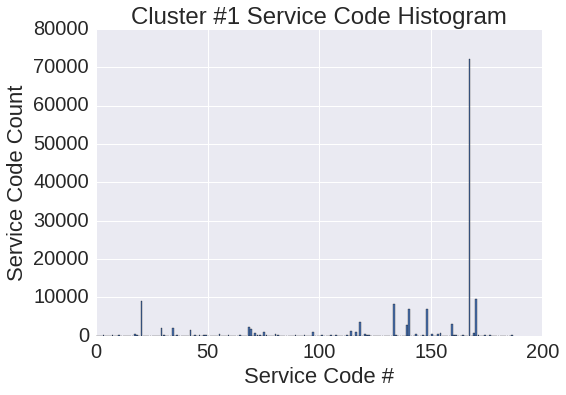

In [7]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

### Apply a word tokenizer (with stemming)  to the service names and construct a TF-IDF feature matrix

In [8]:
params = {'maxdocumentfrequency': 0.25,
          'mindocumentcount': 10}

(tfidf_matrix,
 tfidf_vectorizer) = compute_tfidf_features(code_name_map,
                                            tokenize_and_stem,
                                            params)

print "# of terms: %d" % (tfidf_matrix.shape[1])
print tfidf_vectorizer.get_feature_names()

# of terms: 33
[u'additn', u'build', u'cart', u'collect', u'com', u'complaint', u'compliment', u'damag', u'default', u'dote', u'gallon', u'grasswe', u'haz', u'inspect', u'litter', u'miss', u'new', u'park', u'priv', u'prop', u'properti', u'recycl', u'repair', u'req', u'request', u'res', u'row', u'servic', u'sign', u'street', u'tall', u'trash', u'tree']


### Apply the [K-means algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the Cincinnati 311 service names based on their TF-IDF feature vector

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 163 | total count: 125123
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666


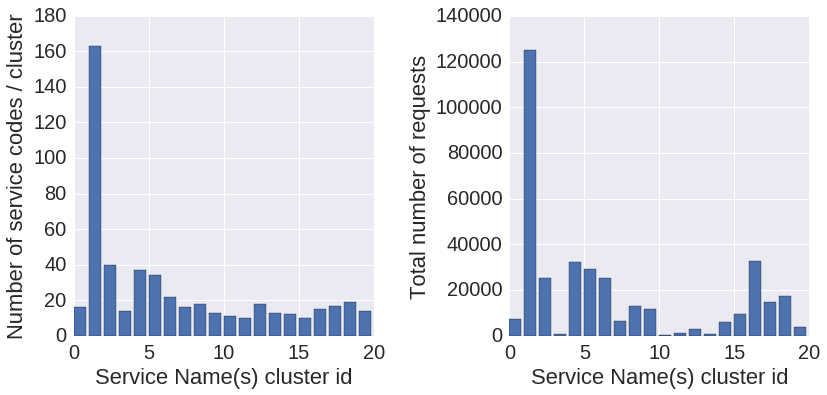

In [9]:
num_clusters = 20
kmeans_seed = 3806933558

(clusterid_code_map,
 clusterid_name_map) = cluster_311_services(tfidf_matrix,
                                            num_clusters,
                                            kmeans_seed)

clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

plot_cluster_stats(clusterid_code_map,
                       clusterid_total_count)

### Plot the service code histogram for the maximum size cluster

max count code: mtlfrn


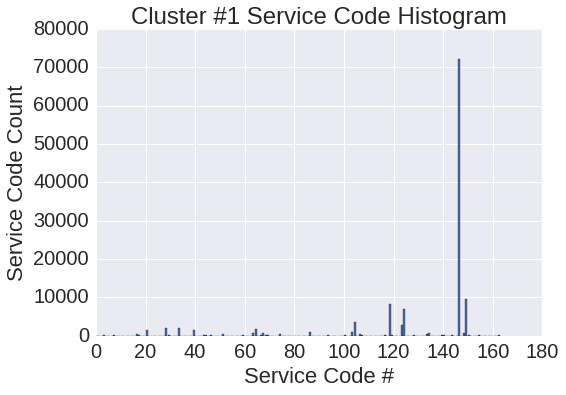

In [10]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

### Create a separate service name(s) cluster for the 'mtlfrn' service code

In [11]:
add_new_cluster(1,
                'mtlfrn',
                clusterid_total_count,
                clusterid_code_map,
                clusterid_name_map)

### Evaluate the service name(s) cluster statistics

In [12]:
clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 162 | total count: 52932
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666
cl

### Plot the service code histogram for the maximum size cluster

max count code: ydwstaj


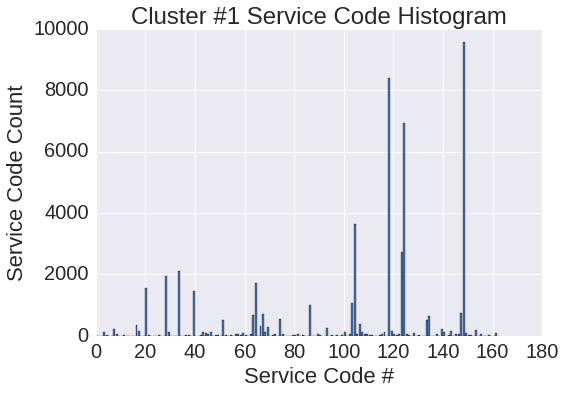

In [13]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

### Create a separate service name(s) cluster for the 'ydwstaj' service code

In [14]:
add_new_cluster(1,
                'ydwstaj',
                clusterid_total_count,
                clusterid_code_map,
                clusterid_name_map)

### Evaluate the service name(s) cluster statistics

In [15]:
clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 161 | total count: 43365
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666
cl

### Plot the service code histogram for the maximum size cluster

max count code: grfiti


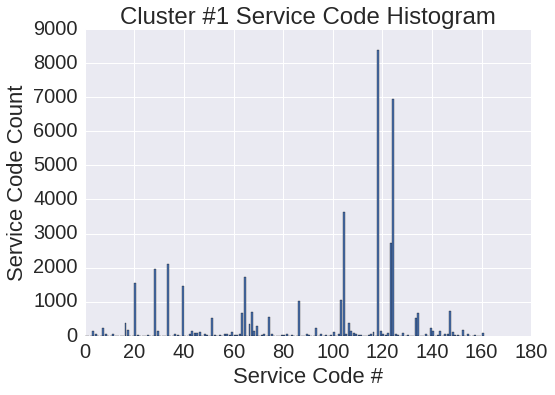

In [16]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

### Create a separate service name(s) cluster for the 'grfiti' service code

In [17]:
add_new_cluster(1,
                'grfiti',
                clusterid_total_count,
                clusterid_code_map,
                clusterid_name_map)

### Evaluate the service name(s) cluster statistics

In [18]:
clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 160 | total count: 34976
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666
cl

### Plot the service code histogram for the maximum size cluster

max count code: dapub1


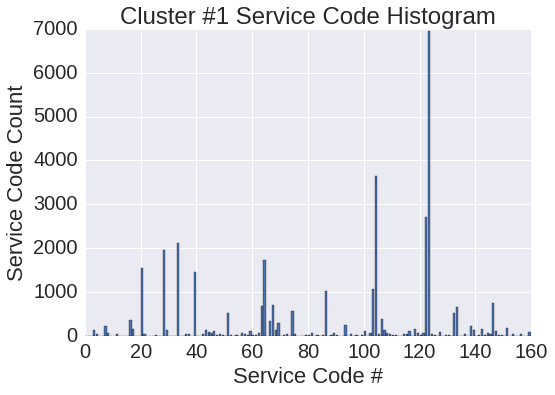

In [19]:
eval_maxcount_clusterid(clusterid_code_map,
                        clusterid_total_count,
                        code_histogram)

### Create a separate service name(s) cluster for the 'dapub1' service code

In [20]:
add_new_cluster(1,
                'dapub1',
                clusterid_total_count,
                clusterid_code_map,
                clusterid_name_map)

### Evaluate the service name(s) cluster statistics

clusterid 0 | # of codes: 16 | total count: 7260
clusterid 1 | # of codes: 159 | total count: 28034
clusterid 2 | # of codes: 40 | total count: 25091
clusterid 3 | # of codes: 14 | total count: 718
clusterid 4 | # of codes: 37 | total count: 32299
clusterid 5 | # of codes: 34 | total count: 29379
clusterid 6 | # of codes: 22 | total count: 25306
clusterid 7 | # of codes: 16 | total count: 6438
clusterid 8 | # of codes: 18 | total count: 13252
clusterid 9 | # of codes: 13 | total count: 11748
clusterid 10 | # of codes: 11 | total count: 216
clusterid 11 | # of codes: 10 | total count: 1091
clusterid 12 | # of codes: 18 | total count: 3053
clusterid 13 | # of codes: 13 | total count: 982
clusterid 14 | # of codes: 12 | total count: 5913
clusterid 15 | # of codes: 10 | total count: 9446
clusterid 16 | # of codes: 15 | total count: 32572
clusterid 17 | # of codes: 17 | total count: 14571
clusterid 18 | # of codes: 19 | total count: 17540
clusterid 19 | # of codes: 14 | total count: 3666
cl

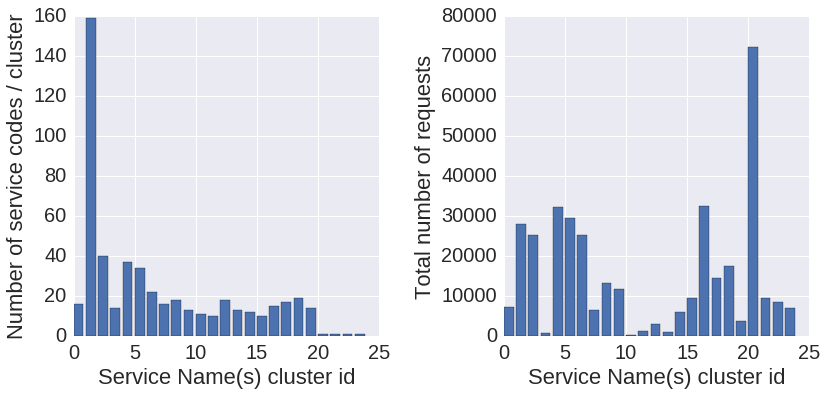

In [21]:
clusterid_total_count =\
    compute_clusterid_totalcounts(clusterid_code_map,
                                  code_histogram)
    
print_cluster_stats(clusterid_name_map,
                    clusterid_total_count)

plot_cluster_stats(clusterid_code_map,
                       clusterid_total_count)

### Label each service name(s) cluster

In [22]:
cur_clusterid = 0
clusterid_category_map = {}
clusterid_category_map[cur_clusterid] = 'streetmaintenance'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

street roadway widening
street sweeping
street dote street opening
revocable street privilege
street plates slippery street
street dote street blocking
street asphalt repair        
street plates inlet placerem
street repavedresurfaced
street heaved area
general repair street
void dote in street
street cleaning
street plates dote plates haz
street flashfill structures
street flashfill dunbar


In [23]:
clusterid_category_map[cur_clusterid] = 'miscellaneous'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

handbill prohibit dstrb 
buildhaz during constexistr 
electricalsingle applncearc
furniture at the curb
misc traffc study cntaccident
animal bitescratchoth domest
elevator hazard
sidewalk bushes encumbering
row tire dumping
sink holeearth condition pph
gratemetal theftvandalism
unregistered contractor ins
pavement priv w no drainage
exit blocked 
weeds brush as fire hazard
school roaches in or around 
animal waste in the yard
zoning cncntrtd code enf com 
rodentinsect infest nurse hm
carpentry overhead door
restaurant consult new lic
cincinnati bell
wesleyan new resident
elevator slow
institution def plumbing
inlets clogged rainingpondng
building weeds priv property
unsanitary condtn hotelmotel
vehicle abandon priv p access
noticesign posted on a pole
swimming poolspa safe concrn
sweeping parking enforcement
animal bitescratch wild
corner can overflowing
yard plumbing leak
fire escape unsafe blocked
littertall grassweeds dote 
media advisory
school mold 
unsanitary living conditions
sw

In [24]:
clusterid_category_map[cur_clusterid] = 'trashcart'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

trash cart repair 95 gallon
trash cart swap 95 gallon
trash cart remove
trash cart new 65 gallon
trash cart new 95 gallon
trash cart additnal 041115
trash cart additnal 040415
trash cart additnal 031415
trash cart additnal 030715
trash cart additnal 022815
trash cart additnal 022115
trash cart repair 35 gallon
trash cart swap 35 gallon
trash cart new 35 gallon
trash cart swap 65 gallon
trash cart additnal 020715
trash cart additnal 021415
trash cart additnal  122714
trash cart additnal 010315
trash cart additnal 011015
trash cart additnal 011715
trash cart additnal 013115
trash cart additnal 062715
trash cart additnal 072515
trash cart additnal 052315
trash cart additnal 050215
trash cart additnal 050915
trash cart additnal 061315
trash cart additnal 053015
trash cart additnal 060615
trash cart additnal 042515
trash cart additnal 012415
trash cart registration
trash cart exemption
trash cart repair 65 gallon
trash cart additnal 082215
trash cart additnal 080815
trash cart additnal 0516

In [25]:
clusterid_category_map[cur_clusterid] = 'buildinghazzard'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

building electric haz
barricade setupremove haz
bridgesrepair haz
litter stepswalkway no haz
water no water haz
litter stepswalkway haz ah
build haz cnstr condnewcom
graffiti haz
build haz cnstr cond nwcm ins
building plmb haz during cons
handrails damagedmissing haz
litter stepswalkway haz rh
pool priv pool enclosure haz
dumpster overflow row haz


In [26]:
clusterid_category_map[cur_clusterid] = 'buildingcomplaint'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

building disaster resvacant
rats in a building
build permit vio dur const er
building electric permit viol
building hvac hazard ins
unregistered contractor build
construct build wo permit ins
building demo disastercom
building prmt cnflct w con c
building prmt cnflct w con r
building cde vio dur constrn
building commercial cbhcodec
building prob new bldg const 
building hvac permit violatn
housingcra new building
building demo disasterres
building concentratd code enf
mice building has mice
building hvac permit viol ins
building com concntrtd code e
build permit vio dur const nc
building barricade case 
building demo city ownedcom
building demo city ownedres
rats outside a building
mold building or apartment
building hvac hazard
building disaster comvacant
animal waste in a building
building ovrcrowding resident
building residential
building condemn requestcom
building collapsing 
sewage in building
constructn build wo permit 
building vacant and open com
building plmb permit violatn


In [27]:
clusterid_category_map[cur_clusterid] = 'repairrequest'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

parking meter repair
bridge repair
guardrail repair haz
utility repairs dote 
pothole repair after hours
sidewalk repair asphalt
guardrail repair
wall repair problem near str
sidewalk temporary repair
handrails repair
recycling repair 96
sidewalk repair structures
sunken area repair
pothole repair
attenuator repair
restoration repair cww
fire hydrant repair cww
gm barrier repair haz
ps stormwater inlet repair
recycling repair 35
city facility repair
signal audible signal repair
curbs repair
recycling repair 64
light pedestal repair
fire hydrant repair
signal trafpedschool repair
wall repair problem in st haz
light repair
steps repair
steps repair haz
recycling repair 18
sidewalk repair haz
void repair


In [28]:
clusterid_category_map[cur_clusterid] = 'propertymaintenance'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

building tall grass priv prop
tall grassweeds private prop
tall grass weeds rec prop
fence built ovr prop line com
tall grassweeds park prop
tall grassweeds fire propert
landslide private prop stndrd
sewage surfacing priv prop
tall grassweeds econ dev prop
tall grassweeds msd property
tall grassweeds prkng fac
tall grassweeds ps property
tall grassweeds msdsmu prop
tall grassweeds bld dpt prop
hole open foundatn priv prop
tall grassweeds prop health
container private prop
tall grassweeds cdp prop
talll grassweeds gcww prop
dumping prv prop 2500 sq ft
building illegal use com prop
refrigerator aban prv prop


In [29]:
clusterid_category_map[cur_clusterid] = 'defaultrequest'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

default parks
default parking
default mayors office
default law
default cww
default human resources
default fleet services
default city
default community development
default msd
default trade and development
default recreation
default rcc
default conv ctr
default msd stormwater
default police and junk veh


In [30]:
clusterid_category_map[cur_clusterid] = 'propertycomplaint'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

dead animal private property
tires special collection
missing property collections
property damage ps stormwater
property damage traffic aids
construction damage claim
special collections rtc
yard waste tagged collections
dumpster special collection
pup truck collection
property damage collections
signage problem comm property
property damage asphalt
property damage tsb
property damage greenspace
property damage structures
property damage row
property damage facility mngt


In [31]:
clusterid_category_map[cur_clusterid] = 'trashcomplaint'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

trash can damaged
trash offensive discharge
trash improper set out
trash early set out
trash tagged collections
trash unacceptable container
trash set out service
trash commercial nonmaintain
trash late set out 
trash no trash at location
trash on arrival
trash can condemned
trash tagged bed bugs


In [32]:
clusterid_category_map[cur_clusterid] = 'servicecompliment'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

service compliment trash
service compliment trod
service compliment greenspace
service compliment nip
service compliment cust serv
service compliment cww
service compliment dote
service compliment recreation
food service unlicensed oper
service compliment yardwaste
service compliment str clean


In [33]:
clusterid_category_map[cur_clusterid] = 'inspection'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

special fire inspection
6 month inspection
healthy homes inspection
postfire inspection
life safety 6month inspection
2 month inspection
housingcra maint inspection
grass cutting city inspection
sidewalk repairs inspection
landslide inspect for struct


In [34]:
clusterid_category_map[cur_clusterid] = 'servicecomplaint'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

service complaint cascade
service complaint trod
service complaint rumpke
railroads complaints
service complaint yardwaste
airport noise complaints
school general complaint
service complaint greenspace
school cafeteria complaints
service complaint nip
service complaint str clean
service complaint recreation
food borne complaint 1person
service complaint dote
service complaint cww
service complaint trash
service complaint cust serv
contractor complaint


In [35]:
clusterid_category_map[cur_clusterid] = 'buildinginspection'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

bb req for inspnew
bed bugs req for info only
carbon monoxide test req  
building fire req inspcom
rooming hse req for inspnew
bb req for insp existing
rats in sewer rem req
building fire req inspres
sting insect rem req priv
building adult care req ins
building daycare req for insp
building emerg shlt req ins
building disaster com ins req


In [36]:
clusterid_category_map[cur_clusterid] = 'buildingcomplaint'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

business operating fm res
building illegal use res prop
parking grass front yd res
fence height or material res
light shining into bldg res
signage problem res property
fence built ovr prop line res
landuse nonpermttd use res
building condemnation res
building disaster res ins req
building vacant and open res 
zoning cncntrtd code enf res


In [37]:
clusterid_category_map[cur_clusterid] = 'signmaintenance'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

sign downmissing 
sign overhead newchange
sign grnd mnted newchangrem
sign overhead repair
sign street sign faded
sign street sign name missing
sign handicap parking signs
sign downmissing stop sign
sign gatewywelcome reprrepl
sign exit broken or missing


In [38]:
clusterid_category_map[cur_clusterid] = 'requestforservice'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

sign shopexternal new request
sign shopinternal new request
relocation survey request
slippery streets request haz
trash request for collection
information request
signal change request traffic
trash request for new service
insect identification request
relocation request
building request cert of insp
slippery streets request
food operation request gen
recycling information request
recycling request to collect


In [39]:
clusterid_category_map[cur_clusterid] = 'litter'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

litter commun dev property
litter health dept prop
litter row large items
litter sweep to sidewlkroad
litter econ dev prop
litter msd property
building litter on priv prop
litter park dept property
litter restaurant property
litter airport property
litter recreation property
litter sweep into gutter
litter gcww  property 
litter parking fac prop
litter private property
litter bldg dept property
litter from vehicles


In [40]:
clusterid_category_map[cur_clusterid] = 'recycling'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid +=1 

recycling new 35 gallon cart
recycling cart missing 18
recycling swap cart 18
trash cart missing 65 gallon
trash cart missing 95 gallon
recycling swap cart 96
recycling cart missing 96
trash cart missing 35 gallon
recycling remove cart
recycling swap cart 35
recycling new 96 gallon cart
recycling cart missing 35
recycling new 18 gallon cart
recycling remove cart vacant
recycling newswapmissing cart
recycling cart missing 64
recycling contaminated cart
recycling new 64 gallon cart
recycling swap cart 64


In [41]:
clusterid_category_map[cur_clusterid] = 'treemaintenance'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

tree after hrs no storm
tree planting request
tree limbs down  row 
tree blocking visibilitypub
tree dead on priv prop haz
tree blocking visbilitypriv
tree stump removal in row
tree trim required public
tree split or hanging
tree remove hornet nestsrow
tree trim requird private 
tree wood pickup
tree removal requestpub tree
tree dead on priv prop stndrd


In [42]:
clusterid_category_map[cur_clusterid] = 'metalfurniturecollection'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

metal furniture spec collectn


In [43]:
clusterid_category_map[cur_clusterid] = 'yardwaste'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

yard wastertc


In [44]:
clusterid_category_map[cur_clusterid] = 'graffitiremoval'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

graffiti removal


In [45]:
clusterid_category_map[cur_clusterid] = 'deadanimal'

print_clustered_servicenames(cur_clusterid,
                             clusterid_name_map)

cur_clusterid += 1

dead animal


In [46]:
clusterid_category_map

{0: 'streetmaintenance',
 1: 'miscellaneous',
 2: 'trashcart',
 3: 'buildinghazzard',
 4: 'buildingcomplaint',
 5: 'repairrequest',
 6: 'propertymaintenance',
 7: 'defaultrequest',
 8: 'propertycomplaint',
 9: 'trashcomplaint',
 10: 'servicecompliment',
 11: 'inspection',
 12: 'servicecomplaint',
 13: 'buildinginspection',
 14: 'buildingcomplaint',
 15: 'signmaintenance',
 16: 'requestforservice',
 17: 'litter',
 18: 'recycling',
 19: 'treemaintenance',
 20: 'metalfurniturecollection',
 21: 'yardwaste',
 22: 'graffitiremoval',
 23: 'deadanimal'}

### Plot Cincinnati 311 Service Name Categories

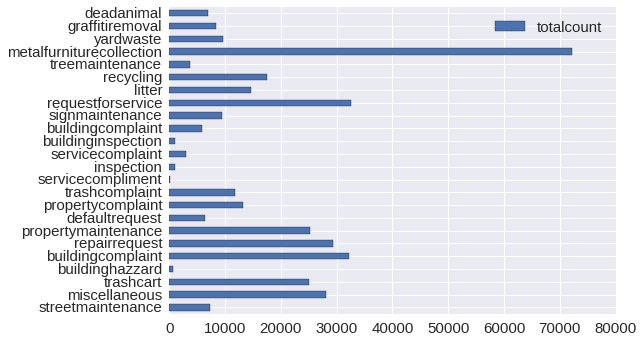

In [47]:
import pandas as pd

category_totalcountdf =\
    pd.DataFrame({'totalcount': clusterid_total_count.values()},
                 index=clusterid_category_map.values())
    
sns.set(font_scale=1.5)
category_totalcountdf.plot(kind='barh')

### Write service code / category map to disk
- [Storing Python Dictionaries](http://stackoverflow.com/questions/7100125/storing-python-dictionaries)

In [48]:
servicecode_category_map = {}

for clusterid in clusterid_name_map.keys():
    cur_category = clusterid_category_map[clusterid]
    
    for servicecode in clusterid_code_map[clusterid]:

        servicecode_category_map[servicecode] = cur_category
        
with open('serviceCodeCategory.txt', 'w') as fp:
    num_names = len(servicecode_category_map)

    keys = servicecode_category_map.keys()
    values = servicecode_category_map.values()

    for idx in range(0, num_names):
        if idx == 0:
            fp.write("%s{\"%s\": \"%s\",\n" % (" " * 12,
                                               keys[idx],
                                               values[idx]))
        #----------------------------------------
        elif idx > 0 and idx < num_names-1:
            fp.write("%s\"%s\": \"%s\",\n" % (" " * 13,
                                              keys[idx],
                                              values[idx]))
        #----------------------------------------
        else:
            fp.write("%s\"%s\": \"%s\"}" % (" " * 13,
                                            keys[idx],
                                            values[idx]))